In [1]:
# list of imports

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig 

# The mpl commands are how I like to format my matplotlib plots, so feel free to ignore them.
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 10.0)     # set figure size
mpl.rcParams['font.family'] = 'Serif'      # set font
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.size'] = 17
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['xtick.top'] = True  
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 18
mpl.rcParams['xtick.major.pad'] = 14
mpl.rcParams['ytick.major.pad'] = 14

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['ytick.major.size'] = 18
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25

from astropy.convolution import convolve, Box2DKernel, Gaussian2DKernel
from astropy.io import fits

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    
warnings.filterwarnings('ignore')

# CubeCarve

### This notebook will act as an example on how you can run CubeCarve, and considerations you can make while using it.

### For this to work, you must properly install the package on your machine to access the simple cubecarve pipeline

# Import CubeCarve

In [2]:
from cubecarve import CubeCarve

# CubeCarve is the class object that runs the simple pipeline

# Load in your 3D data

### For this example, we will load in the simulated datacube stored in the /data folder. This example data is very simple, as it does not have a true header file. All we care about right now is the 3D numpy array structure

In [3]:
hdul = fits.open('../data/testcube_lowres.fits')
cube = hdul[0].data

# Inspect your 3D data prior to loading *CubeCarve*

    - Where are the bright Point sources located?
    - Create a 2D array equal to the 2D spatial size of your datacube of all zeros
    - At the pixel locations of the pointsources, assign their value to 1. - First guess of their location
    

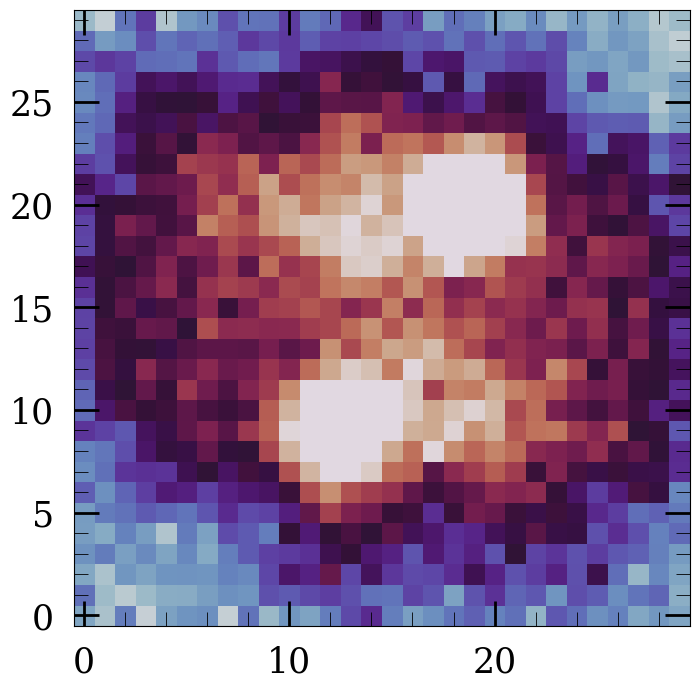

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(cube[203],origin='lower',cmap='twilight',vmax=0.32,vmin=-0.04)
plt.show()

# this test case is simple, simply because we built the cube ourselves.
# but let's make the 2D pointsource array:

# CubeCarve will build Model PSF based on those positions
pointsources = np.zeros_like(cube[0])
pointsources[20,19] = 1 
pointsources[9,12] = 1 

# Now Initialize *CubeCarve*

    - Provide Cube
    - scale factor to supersize image (let's use 6)
    - The x and y pixelsize in arcseconds. We will assume 1" x 1" pixels
    

In [5]:
# run cubecarve

scale_factor = 6
CC = CubeCarve(cube,scale_factor,pointsources,xpixelsize=1,ypixelsize=1)

# Create Empirical PSF Model Cube
    - Specify which index values/ wavelength layers you have interest in. If you want to run the code on the whole cube, do not provide an index array
    - Specify which wavelength layers contain extended emission (such as the Lyman-alpha line). *CubeCarve* will exclude these wavelengths from being used to generate the PSF model, but those wavelengths will still possess a PSF model.


In [6]:
# make psf cube
# restrict these wavelength layers from being used to generate PSF model
deactivate = np.array([])
deactivate = np.arange(180,220,1)

n_layers = 200 # layers combined via mean for a single psf model
Xpsf = 6
Ypsf = 6 # in arcseconds since we set pixelsize=1

index = np.array([203]) # only a single index, add more to run cubecarve on more wavelengths in the cube
CC.build_psf_cube(deactivate,200,Xpsf,Ypsf,index)

Empirical PSF Model(s) Built
Ready to run


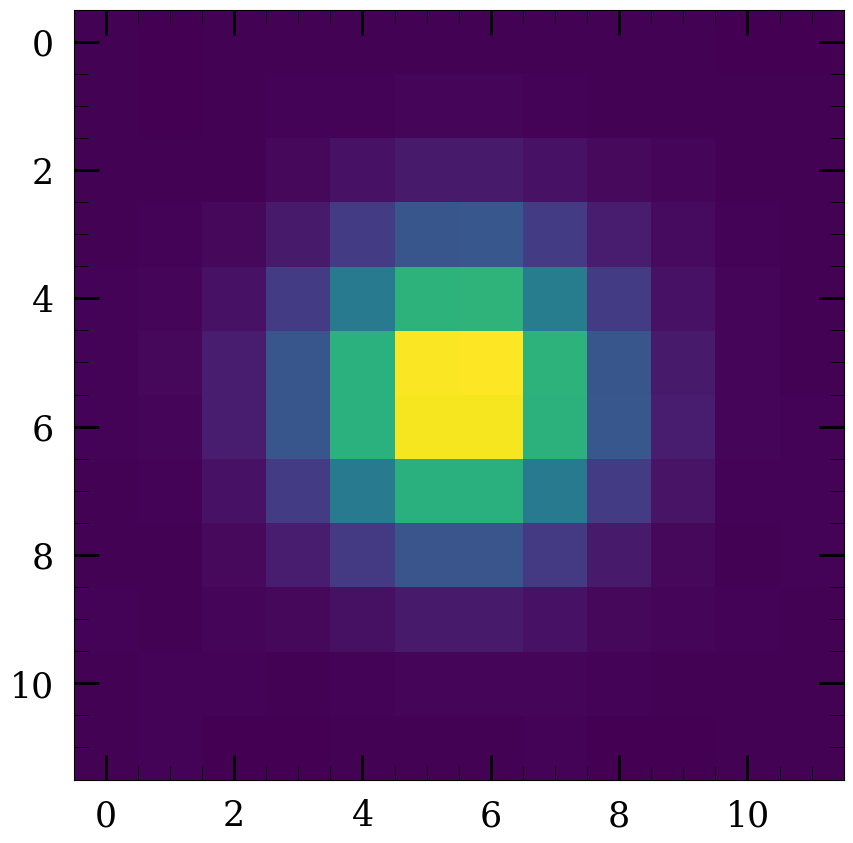

In [7]:
# Inspect the PSF

plt.imshow(CC.psf_cube[index[0]])
plt.show()

# Run the deconvolution/extraction with *CubeCarve*

    - Provide the number of iterations the algorithm should run for
    - provide the resolution kernel fwhm size. Larger fwhm adds a harsher penalty to unresolved pockets in the resolved flux model
    - select a sigma value that performs a simple gaussian smoothing to the resolved flux to handle noise spikes

In [8]:
Nsteps = 800
Rsize = 6
sigma = 1.1

CC.run(Nsteps, Rsize, sigma=sigma)

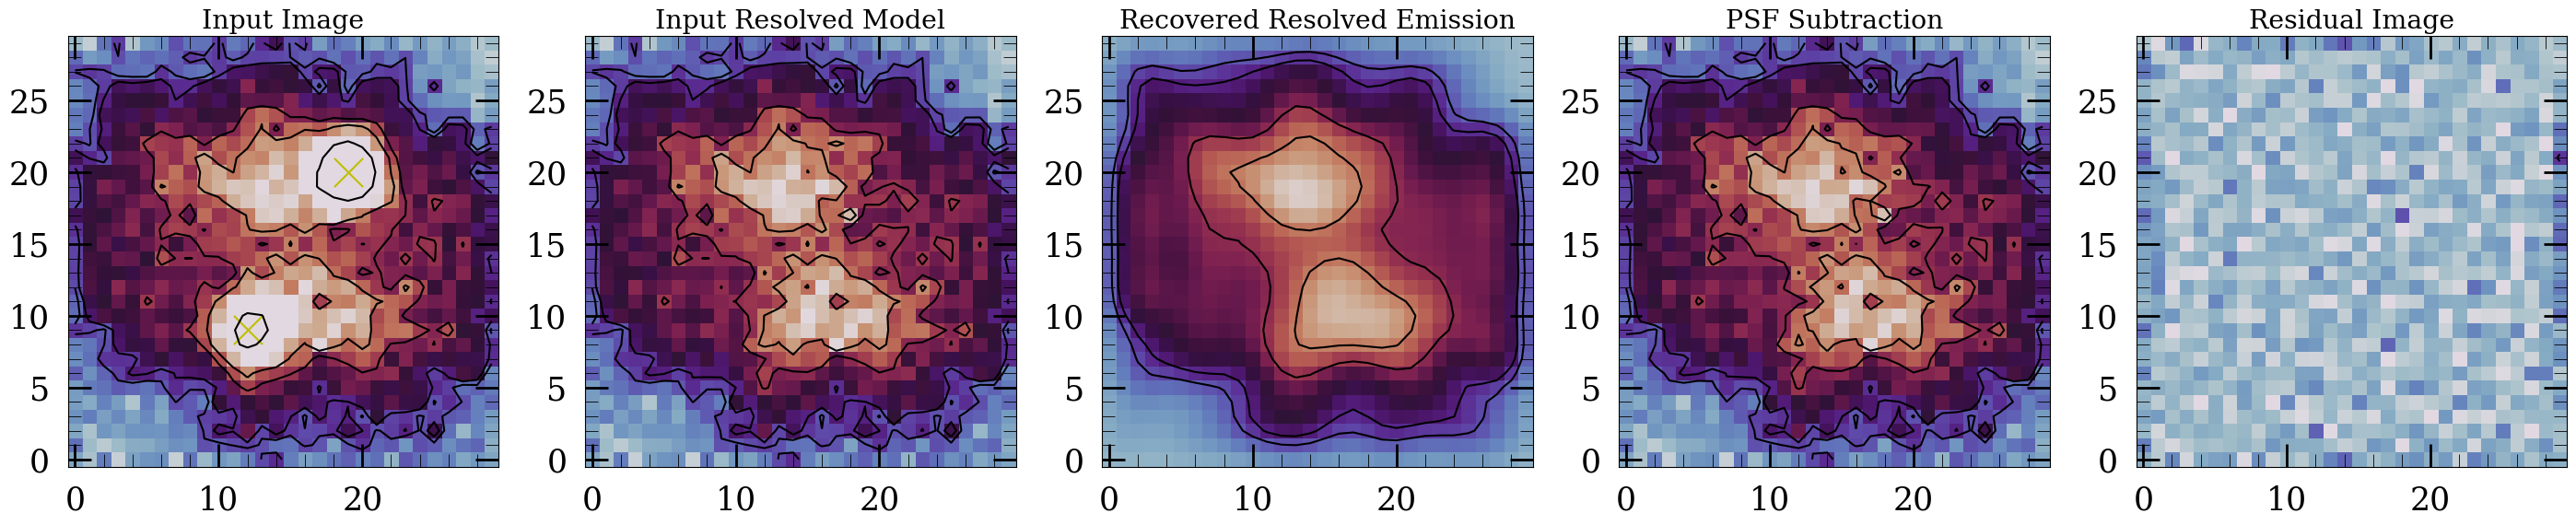

In [9]:
mosaic = np.array([[1,2,3,4,5]])

vmax = 0.32
vmin = -0.04

# Let's plot the results to see how we did...
# Just index 203 since that was the chosen index
fig, axes = plt.subplot_mosaic(mosaic,figsize=(35,18))
axes[1].imshow(CC.cube[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[1].contour(CC.cube[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[1].scatter(19,20,c='y',marker='x',s=500)
axes[1].scatter(12,9,c='y',marker='x',s=500)
axes[1].set_title('Input Image')

# load in cube that has no point sources to compare CubeCarve performance.
hdul = fits.open('../data/testcube_nostars_lowres.fits')
cube_resolved  = hdul[0].data

axes[2].imshow(cube_resolved[203],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[2].contour(cube_resolved[203],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[2].set_title('Input Resolved Model')

axes[3].imshow(CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[3].contour(CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[3].set_title('Recovered Resolved Emission')

axes[4].imshow(CC.cube[index[0]]-CC.unresolved[index[0]],origin='lower', cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[4].contour(CC.cube[index[0]]-CC.unresolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[4].set_title('PSF Subtraction')

axes[5].imshow(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[5].contour(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[5].set_title('Residual Image')


plt.show()


# What if I want to run on a range of wavelength layers?

No problem, just add more values to your index array!

In [9]:
# Let's change the index array here:

index = np.arange(190,210,1)

# we must rerun the build psf cube function!
# Same parameters as before, but we now build more psf models!
CC.build_psf_cube(deactivate,200,Xpsf,Ypsf,index)

Empirical PSF Model(s) Built
Ready to run


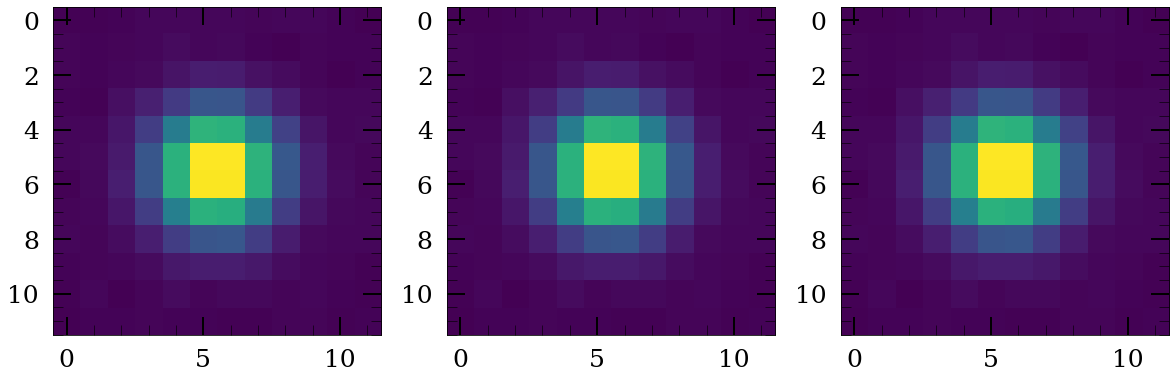

In [10]:
# Let's look at some of them...

mosaic = np.array([[1,2,3]])

# Let's plot the results to see how we did...
# Just index 203 since that was the chosen index
fig, axes = plt.subplot_mosaic(mosaic,figsize=(20,10))
axes[1].imshow(CC.psf_cube[194])
axes[2].imshow(CC.psf_cube[200])
axes[3].imshow(CC.psf_cube[208])
plt.show()

In [11]:
# Now run CubeCarve again
# it will automatically run on the new index array :)
# WARNING: This may take ~ 2 minutes to run on your machine
Nsteps = 800
Rsize = 6
sigma = 1.1

CC.run(Nsteps, Rsize, sigma=sigma)

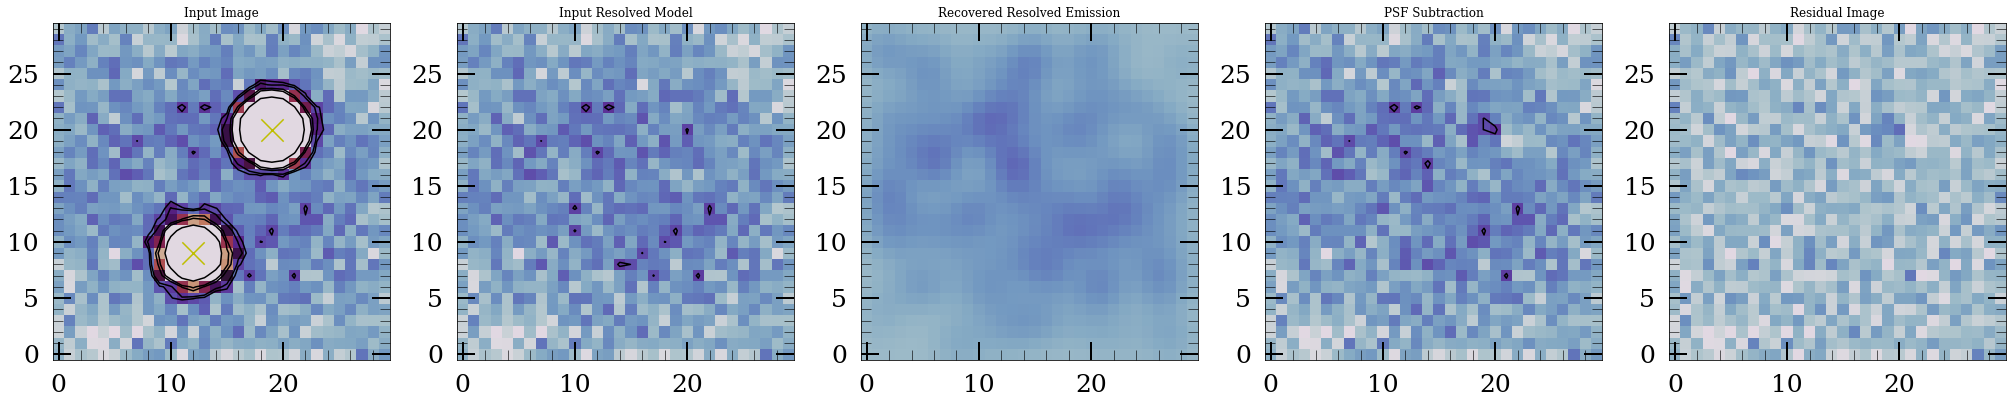

In [12]:
# Check the results on index[0], which corresponds to 190

mosaic = np.array([[1,2,3,4,5]])

vmax = 0.32
vmin = -0.04

# Let's plot the results to see how we did...
# Just index 203 since that was the chosen index
fig, axes = plt.subplot_mosaic(mosaic,figsize=(35,18))
axes[1].imshow(CC.cube[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[1].contour(CC.cube[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[1].scatter(19,20,c='y',marker='x',s=500)
axes[1].scatter(12,9,c='y',marker='x',s=500)
axes[1].set_title('Input Image')

# load in cube that has no point sources to compare CubeCarve performance.
hdul = fits.open('../data/testcube_nostars_lowres.fits')
cube_resolved  = hdul[0].data

axes[2].imshow(cube_resolved[190],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[2].contour(cube_resolved[190],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[2].set_title('Input Resolved Model')

axes[3].imshow(CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[3].contour(CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[3].set_title('Recovered Resolved Emission')

axes[4].imshow(CC.cube[index[0]]-CC.unresolved[index[0]],origin='lower', cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[4].contour(CC.cube[index[0]]-CC.unresolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[4].set_title('PSF Subtraction')

axes[5].imshow(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[5].contour(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[5].set_title('Residual Image')


plt.show()


# Let's see how *CubeCarve* does on higher res test cube



In [10]:
hdul = fits.open('../data/testcube_highres.fits')
cube = hdul[0].data

# Let's just use one cell for the prep this time 
deactivate = np.arange(180,220,1)
pointsources = np.zeros_like(cube[0])
# Declare/Guess the Positions of Point Sources in your Image/Cube
# CubeCarve will build Model PSF based on those positions
pointsources[55,41] = 1 # 29 for 1399-1400
pointsources[45,60] = 1 # 29 for 1399-1400

# notice that I reduce the scale down to 4 this time
scale_factor = 4
CC = CubeCarve(cube,scale_factor,pointsources,xpixelsize=1,ypixelsize=1)

In [11]:
# make psf cube
# same index as before
index = np.array([203])
Xpsf = 6 # larger psf window size this time
Ypsf = 6
nlayers = 200 # same # of layers
CC.build_psf_cube(deactivate,nlayers,Xpsf,Ypsf,index)

Empirical PSF Model(s) Built
Ready to run


# Varying Parameters:

- Increasing R size
- change the sigma value (smooths resolved model to reduce noise impact on each iteration)
- Larger or small PSF window sizes
- Parameters used in low-res image may not work as well as for the high-res cube!

In [12]:
N = 700 # steps
Rsize = 15 # larger res kernel
CC.run(N,Rsize,sigma=1.5)

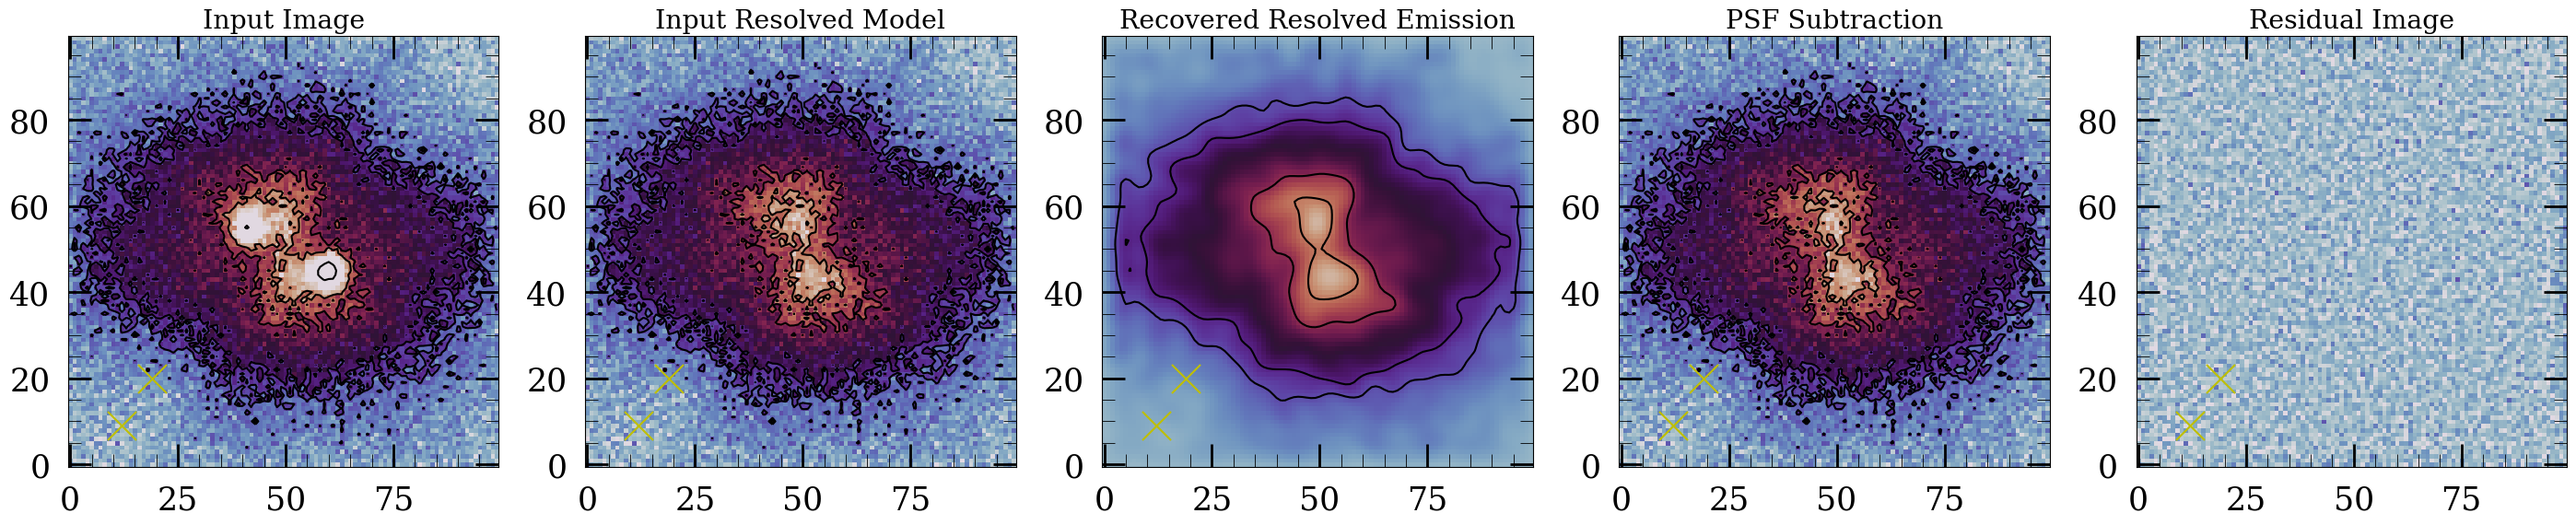

In [13]:
mosaic = np.array([[1,2,3,4,5]])

vmax = 0.32
vmin = -0.04

# Let's plot the results to see how we did...
fig, axes = plt.subplot_mosaic(mosaic,figsize=(35,18))
axes[1].imshow(CC.cube[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[1].contour(CC.cube[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[1].scatter(19,20,c='y',marker='x',s=500)
axes[1].scatter(12,9,c='y',marker='x',s=500)
axes[1].set_title('Input Image')

# load in cube that has no point sources to compare CubeCarve performance.
hdul = fits.open('../data/testcube_nostars_highres.fits')
cube_resolved  = hdul[0].data

axes[2].imshow(cube_resolved[203],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[2].contour(cube_resolved[203],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[2].scatter(19,20,c='y',marker='x',s=500)
axes[2].scatter(12,9,c='y',marker='x',s=500)
axes[2].set_title('Input Resolved Model')

axes[3].imshow(CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[3].contour(CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[3].scatter(19,20,c='y',marker='x',s=500)
axes[3].scatter(12,9,c='y',marker='x',s=500)
axes[3].set_title('Recovered Resolved Emission')

axes[4].imshow(CC.cube[index[0]]-CC.unresolved[index[0]],origin='lower', cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[4].contour(CC.cube[index[0]]-CC.unresolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[4].scatter(19,20,c='y',marker='x',s=500)
axes[4].scatter(12,9,c='y',marker='x',s=500)
axes[4].set_title('PSF Subtraction')

axes[5].imshow(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[5].contour(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],levels=[0.075,0.1,0.2,0.25,0.5],colors='k')
axes[5].scatter(19,20,c='y',marker='x',s=500)
axes[5].scatter(12,9,c='y',marker='x',s=500)
axes[5].set_title('Residual Image')



plt.show()


# One Final Example: Low-res datacube, but Pointsources are not centered on a pixel.

### The previous cubes had the pointsources assigned to a single pixel prior to blurring with a kernel. In this example, we placed point sources on a higher res grid, prior to reducing the grid size down. As a result, the bright point sources blend with neighboring pixels, so an offset "point". This is a more realistic example, so a larger scale factor is important.

### The notebook is called "testcube_offcenter.fits"

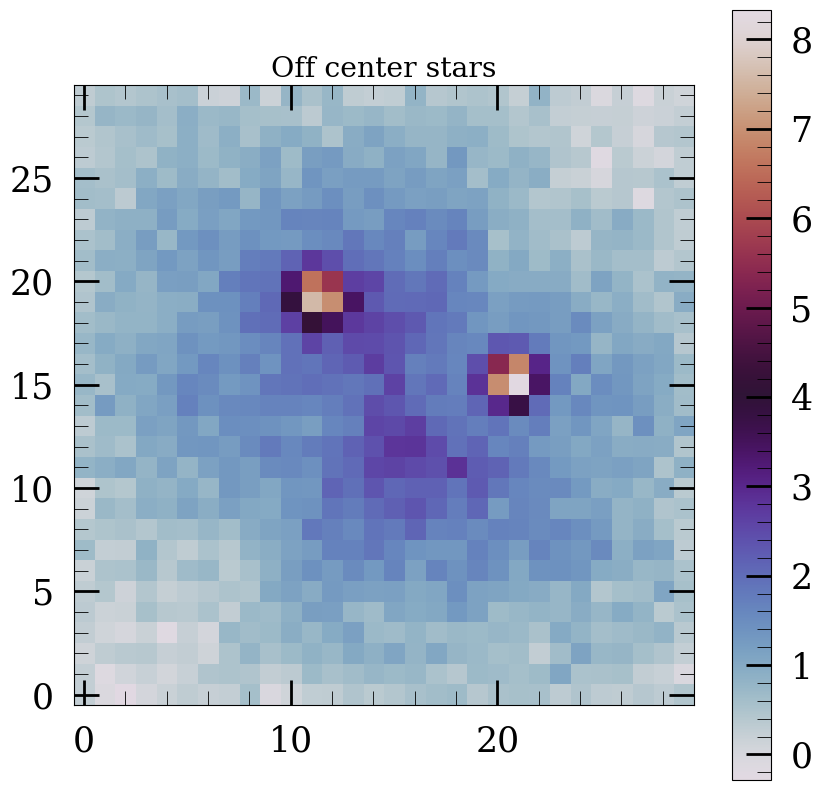

In [14]:
# Examine data

hdul = fits.open('../data/testcube_offcenter.fits')
cube = hdul[0].data

plt.imshow(cube[203],origin='lower',cmap='twilight')
plt.colorbar()
plt.title('Off center stars')
plt.show()


In [15]:
# all steps in a single cell

deactivate = np.array([])
deactivate = np.arange(180,220,1)
pointsources = np.zeros_like(cube[0])
# Declare/Guess the Positions of Point Sources in your Image/Cube
# CubeCarve will build Model PSF based on those positions
pointsources[19,11] = 1 # 29 for 1399-1400
pointsources[15,21] = 1 # 29 for 1399-1400


CC = CubeCarve(cube,9,pointsources,xpixelsize=1,ypixelsize=1)
# # make psf cube
index = np.array([203])
CC.build_psf_cube(deactivate,200,5,5,index) # 1
CC.run(800,10,sigma=2)

Empirical PSF Model(s) Built
Ready to run


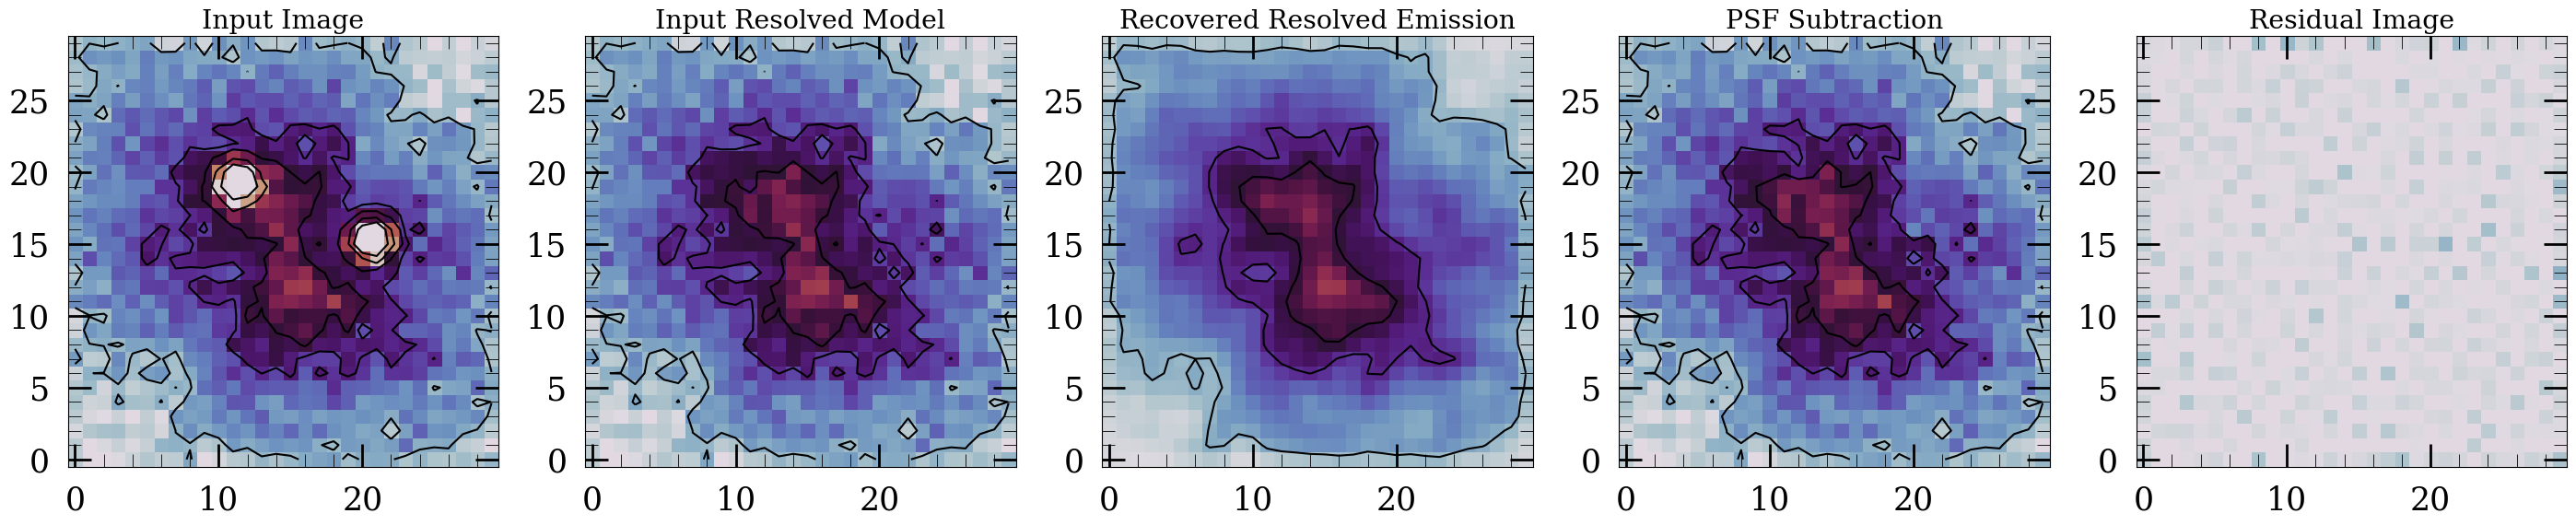

In [20]:
mosaic = np.array([[1,2,3,4,5]])

vmax = 4
vmin = -0.04

# Let's plot the results to see how we did...
fig, axes = plt.subplot_mosaic(mosaic,figsize=(35,18))
axes[1].imshow(CC.cube[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[1].contour(CC.cube[index[0]],levels=[0.5,1.5,2,3,4.5],colors='k')
axes[1].set_title('Input Image')

# load in cube that has no point sources to compare CubeCarve performance.
hdul = fits.open('../data/testcube_offcenter_nostars.fits')
cube_resolved  = hdul[0].data

axes[2].imshow(cube_resolved[203],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[2].contour(cube_resolved[203],levels=[0.5,1.5,2,3,4.5],colors='k')
axes[2].set_title('Input Resolved Model')

axes[3].imshow(CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[3].contour(CC.resolved[index[0]],levels=[0.5,1.5,2,3,4.5],colors='k')
axes[3].set_title('Recovered Resolved Emission')

axes[4].imshow(CC.cube[index[0]]-CC.unresolved[index[0]],origin='lower', cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[4].contour(CC.cube[index[0]]-CC.unresolved[index[0]],levels=[0.5,1.5,2,3,4.5],colors='k')
axes[4].set_title('PSF Subtraction')

axes[5].imshow(CC.cube[index[0]]-CC.unresolved[index[0]]-CC.resolved[index[0]],origin='lower',cmap='twilight',vmin=vmin,vmax=vmax) # ,vmax=0.13,vmin=-0.01    # ,vmin=-0.007,vmax=0.01
axes[5].set_title('Residual Image')

plt.show()
